# Importing Libraries and Loading datasets

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
merged_data = pd.merge(transactions, customers, on="CustomerID")
print("\nMerged Data:")
print(merged_data.head())


Merged Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price     CustomerName         Region  SignupDate  
0      300.68  300.68   Andrea Jenkins         Europe  2022-12-03  
1      300.68  300.68  Brittany Harvey           Asia  2024-09-04  
2      300.68  300.68  Kathryn Stevens         Europe  2024-04-04  
3      601.36  300.68  Travis Campbell  South America  2024-04-11  
4      902.04  300.68    Timothy Perez         Europe  2022-03-15  


# Feature Engineering

In [3]:
# Calculating total spending, number of transactions, and average transaction value for each customer
customer_features = merged_data.groupby("CustomerID").agg(
    TotalSpending=("TotalValue", "sum"),
    NumTransactions=("TransactionID", "count"),
    AvgTransactionValue=("TotalValue", "mean")
).reset_index()

# Adding customer demographics
customer_features = pd.merge(customer_features, customers, on="CustomerID")

print("\nEngineered Features:")
print(customer_features.head())


Engineered Features:
  CustomerID  TotalSpending  NumTransactions  AvgTransactionValue  \
0      C0001        3354.52                5              670.904   
1      C0002        1862.74                4              465.685   
2      C0003        2725.38                4              681.345   
3      C0004        5354.88                8              669.360   
4      C0005        2034.24                3              678.080   

         CustomerName         Region  SignupDate  
0    Lawrence Carroll  South America  2022-07-10  
1      Elizabeth Lutz           Asia  2022-02-13  
2      Michael Rivera  South America  2024-03-07  
3  Kathleen Rodriguez  South America  2022-10-09  
4         Laura Weber           Asia  2022-08-15  


Encode Categorical Variables

In [5]:
# Region
encoder = OneHotEncoder()
encoded_regions = encoder.fit_transform(customer_features[["Region"]]).toarray()
encoded_regions_df = pd.DataFrame(encoded_regions, columns=encoder.get_feature_names_out(["Region"]))

print("\nEncoded Regions:")
print(encoded_regions_df.head())


Encoded Regions:
   Region_Asia  Region_Europe  Region_North America  Region_South America
0          0.0            0.0                   0.0                   1.0
1          1.0            0.0                   0.0                   0.0
2          0.0            0.0                   0.0                   1.0
3          0.0            0.0                   0.0                   1.0
4          1.0            0.0                   0.0                   0.0


Normalize Numerical Features

In [6]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[["TotalSpending", "NumTransactions", "AvgTransactionValue"]])

print("\nScaled Features:")
print(scaled_features[:5])


Scaled Features:
[[-0.06170143 -0.01145819 -0.07026341]
 [-0.87774353 -0.46749414 -0.93493297]
 [-0.40585722 -0.46749414 -0.02627131]
 [ 1.03254704  1.35664965 -0.0767689 ]
 [-0.78392861 -0.92353008 -0.04002806]]


Combine All Features

In [7]:
features = np.hstack([scaled_features, encoded_regions_df])
print("\nCombined Features:")
print(features[:5])


Combined Features:
[[-0.06170143 -0.01145819 -0.07026341  0.          0.          0.
   1.        ]
 [-0.87774353 -0.46749414 -0.93493297  1.          0.          0.
   0.        ]
 [-0.40585722 -0.46749414 -0.02627131  0.          0.          0.
   1.        ]
 [ 1.03254704  1.35664965 -0.0767689   0.          0.          0.
   1.        ]
 [-0.78392861 -0.92353008 -0.04002806  1.          0.          0.
   0.        ]]


Perform K-Means Clustering

In [10]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_features["Cluster"] = kmeans.fit_predict(features)
print("\nClustered Data:")
print(customer_features.head())


Clustered Data:
  CustomerID  TotalSpending  NumTransactions  AvgTransactionValue  \
0      C0001        3354.52                5              670.904   
1      C0002        1862.74                4              465.685   
2      C0003        2725.38                4              681.345   
3      C0004        5354.88                8              669.360   
4      C0005        2034.24                3              678.080   

         CustomerName         Region  SignupDate  Cluster  
0    Lawrence Carroll  South America  2022-07-10        1  
1      Elizabeth Lutz           Asia  2022-02-13        2  
2      Michael Rivera  South America  2024-03-07        1  
3  Kathleen Rodriguez  South America  2022-10-09        0  
4         Laura Weber           Asia  2022-08-15        1  


Calculate Davies-Bouldin Index

In [11]:
db_index = davies_bouldin_score(features, customer_features["Cluster"])
print(f"\nDavies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 1.342184356995347


# Visualize the Clusters

Scatter Plot: Total Spending vs Number of Transactions

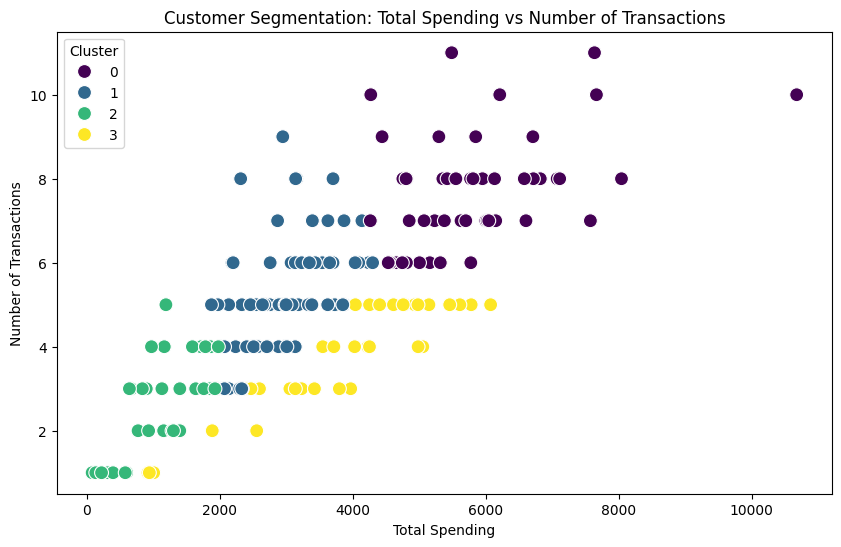

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="TotalSpending",
    y="NumTransactions",
    hue="Cluster",
    data=customer_features,
    palette="viridis",
    s=100
)
plt.title("Customer Segmentation: Total Spending vs Number of Transactions")
plt.xlabel("Total Spending")
plt.ylabel("Number of Transactions")
plt.legend(title="Cluster")
plt.show()

Pair Plot: Total Spending, Number of Transactions, and Average Transaction Value

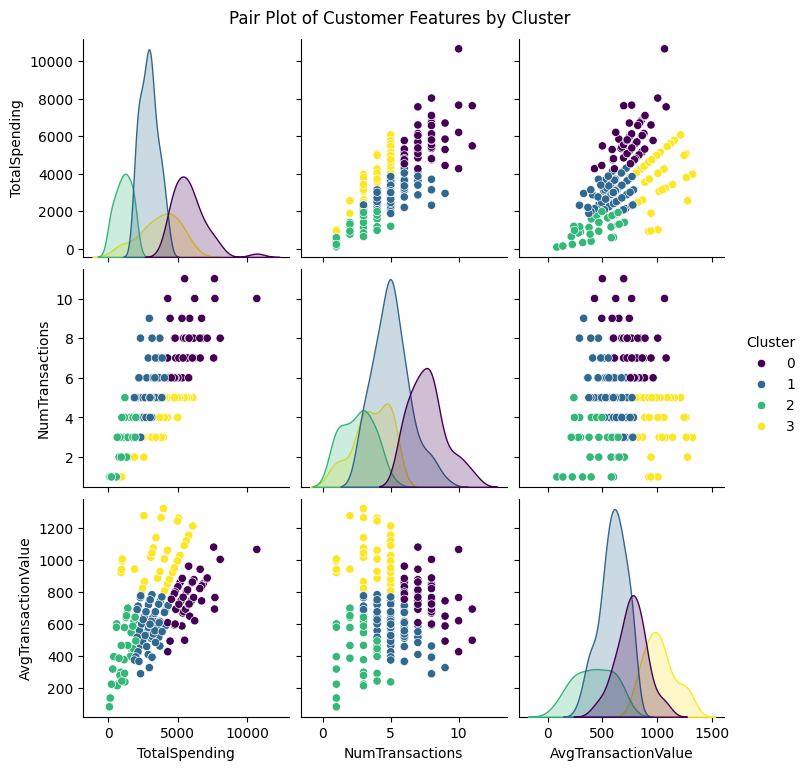

In [13]:
# Pair plot for additional insights
sns.pairplot(customer_features, hue="Cluster", palette="viridis", vars=["TotalSpending", "NumTransactions", "AvgTransactionValue"])
plt.suptitle("Pair Plot of Customer Features by Cluster", y=1.02)
plt.show()

 Saving the clustered data to a CSV file

In [15]:

customer_features.to_csv("DivyaDharshini_J_Clustering.csv", index=False)

print("\nCustomer segmentation completed. Results saved to Clustered_Customers.csv.")


Customer segmentation completed. Results saved to Clustered_Customers.csv.


Other Metrix

Silhouette Score: 0.344138864293847


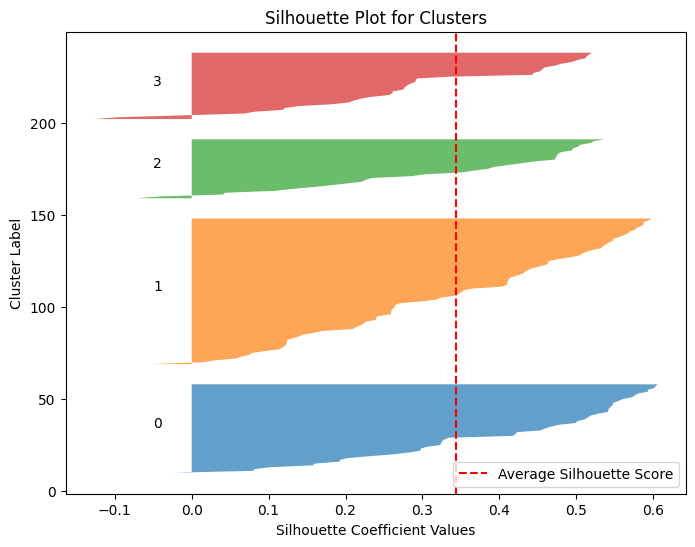

In [24]:
# Import required libraries
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

# already performed K-Means clustering,scaled feature matrix (normalized data),
# K-Means model, n_clusters

# Calculate the average Silhouette Score
X_scaled = scaled_features
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

# Calculate Silhouette Scores for each sample & Ploting
sample_silhouette_values = silhouette_samples(X_scaled, kmeans.labels_)
plt.figure(figsize=(8, 6))
y_lower = 10  # Space between clusters in the plot

# Loop through each cluster to plot the silhouette scores
for i in range(n_clusters):
    # Aggregating the silhouette scores for samples in the current cluster
    ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
    ith_cluster_silhouette_values.sort()

    # size of the cluster
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Filling the area for the current cluster
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      alpha=0.7)

    # Labeling the cluster in the middle of the plot
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # Adding a small gap between clusters

# labels and title to the plot
plt.title("Silhouette Plot for Clusters")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")

# vertical line for the average Silhouette Score
plt.axvline(x=silhouette_avg, color="red", linestyle="--", label="Average Silhouette Score")
plt.legend()
plt.show()